In [2]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [4]:
import json

def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [5]:
XML_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ XML_NAME
data = json_read(DATA_PATH)


Read Json

In [6]:
images = []
bounding_boxes = []
labels = []
image_height = 1920
image_width = 1080

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    one_box.append(annotation['bbox'])
    #one_box.append(annotation['id'])
    #one_box.append(annotation['image_id'])
    bounding_boxes.append(one_box)

print(images)
print(bounding_boxes)


[[1, 'BafoegAntragSeite1Bild1.jpeg'], [2, 'BafoegAntragSeite1Bild2.jpeg'], [3, 'BafoegAntragSeite1Bild3.jpeg']]
[[[192.53, 680.36, 536.13, 282.34]], [[188.04, 1253.83, 549.3, 132.74]], [[192.87, 963.59, 535.84, 287.9]], [[193.48, 597.5, 552.72, 288.8]], [[192.3, 1169.7, 551.84, 128.4]], [[194.17, 888.48, 550.83, 277.32]], [[139.8, 613.2, 554.8, 287.4]], [[139.8, 1194.57, 558.6, 130.23]], [[140.21, 904.8, 557.59, 284.6]]]


[[192.53, 680.36, 536.13, 282.34]]


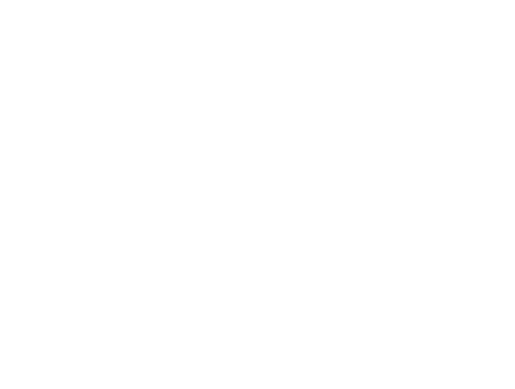

In [7]:
def draw_bounding_boxes(image, box):
    img = cv2.imread(image)
    print(box)
    #for box in boxes: 
    cv2.rectangle(img, (192, 680), (536, 282), (0, 255, 0), 1)

    #cv2.rectangle(img, int((box[0], box[1])), (int(box[0]+ box[2]), int(box[1] + box[3])), (0, 255, 0), 1)

    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

draw_bounding_boxes(IMAGE_PATH+'/original'+ images[0][1],bounding_boxes[0])



Resize images and boxes

In [8]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (height, width))
    #name = image_name + height + 'x' + width
    cv2.imwrite(output_path, resized_image)
    #return resized_image
    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)#int(np.round(box[0]*width_ratio))
        y = np.round(box[1]*height_ratio,2)#int(np.round(box[1]*height_ratio))
        x_width = np.round(box[2]*width_ratio,2)#int(np.round(box[2]*width_ratio))
        y_height = np.round(box[3]*height_ratio,2)#int(np.round(box[3]*height_ratio))
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


Bildgröße zum resizen wählen und Verzeichnisse erstellen

In [9]:
import os

height = 224
width = 224
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(height) + 'x' + str(width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(height) + 'x' + str(width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy XML Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


Resize Bilbder und Bboxen und schreibe diese in das neue Berzeichnis und die neue Datei

In [10]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], height, width)


with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], height, width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=height
    image['width']=width

with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Erstelle TFRecords

In [11]:
import pprint
#RECORDS_DATA_PATH=ANNOTATION_PATH+'/original'+ XML_NAME
RECORDS_DATA_PATH = OUTPUTPATH_ANNOTATIONS + XML_NAME

with open(RECORDS_DATA_PATH, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")
pprint.pprint(annotations[8])

num_samples = 1#4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples


Number of images: 9
{'area': 3839.5800000000004,
 'attributes': {'keyframe': True,
                'occluded': False,
                'rotation': 0.0,
                'track_id': 2},
 'bbox': [29.08, 105.56, 115.65, 33.2],
 'category_id': 3,
 'id': 9,
 'image_id': 3,
 'iscrowd': 0,
 'segmentation': []}


TFRecords Hilfsfunktionen

In [12]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example


Generierung TFRecords

In [13]:
tfrecords_dir = OUTPUTPATH_ANNOTATIONS
images_dir = OUTPUT_PATH_IMAGES

split_ratio = 0.8

num_samples = len(annotations)
print(len(annotations))

num_train_samples = int(split_ratio * num_samples)
num_test_samples = num_samples - num_train_samples

np.random.shuffle(annotations)

train_samples = annotations[:num_train_samples]
test_samples = annotations[num_train_samples:]

#Train
with tf.io.TFRecordWriter(tfrecords_dir + "/train.tfrec") as writer:
    for sample in train_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())
#Test
with tf.io.TFRecordWriter(tfrecords_dir + "/test.tfrec") as writer:
    for sample in test_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())


9


TFRecord Beispiel

bbox: [ 39.88 136.46 114.46  14.98]
area: 1714.61083984375
category_id: 2
id: 5
image_id: 2
path: b'workspace/images/224x224/000000000002.jpeg'
Image shape: (224, 224, 3)


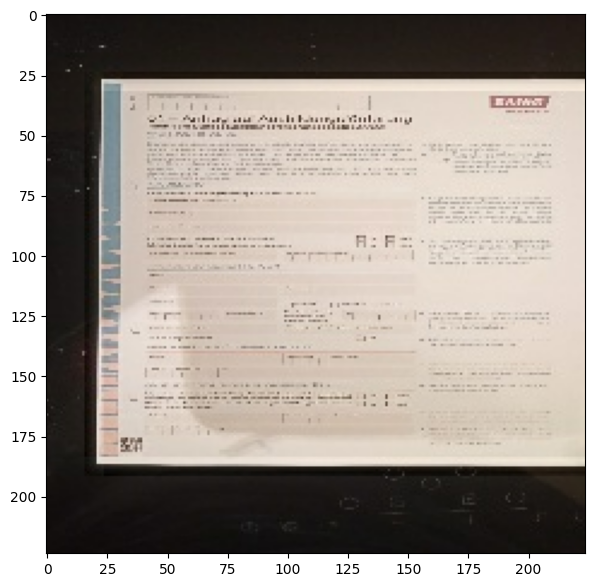

In [14]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/train.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()


In [15]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset


train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 1
epochs = 1
steps_per_epoch = 9
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=91
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(train_filenames, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)





9/9 [==============================] - 42s 346ms/step - loss: 3.7059 - sparse_categorical_accuracy: 0.1111


# Handwriting Recognition RNN Group

In [16]:
import keras
import preprocess
import tokenizer
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [17]:
IMAGE_WIDTH = preprocess.image_width
IMAGE_HEIGHT = preprocess.image_height
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=42),
        tf.keras.layers.RandomContrast(0.5, seed=42)
    ]
)
def build_model9v3():
    input_img = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    x = data_augmentation(input_img)
    x = keras.layers.Conv2D(48, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(x)
    x = keras.layers.Conv2D(96, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = keras.layers.Conv2D(48, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3")(x)
    x = keras.layers.Conv2D(96, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv4")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = keras.layers.Dropout(0.2)(x)
    
    new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 96)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(128, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
                                
    x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    x = keras.layers.Dense(len(tokenizer.char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt)
    return model


In [18]:
rnn = build_model9v3()
rnn.load_weights("alexej_weights.keras")

# Prediction

In [19]:
prediction_model = keras.models.Model(rnn.get_layer(name="image").input, rnn.get_layer(name="dense2").output)

In [20]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :tokenizer.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 3s 3s/step


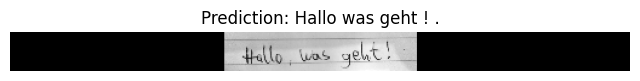

In [21]:
import preprocess

def plot_evaluation(image): # name wird nicht verwendet
    _, ax = plt.subplots(1, 1, figsize=(8, 8))

    img = image
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    preds = prediction_model.predict(tf.expand_dims(image, axis=0))
    pred_texts = decode_batch_predictions(preds)
    
    # Display the prediction at the specified index (default is the first prediction)
    selected_pred_text = pred_texts[0]
    selected_pred_text = selected_pred_text.replace("|"," ")
    title = f"Prediction: {selected_pred_text}"
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    plt.show()



image_path = "data/hallo.jpg" 
img_size=(preprocess.image_width, preprocess.image_height)
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image, 1)
image = preprocess.distortion_free_resize(image, img_size)
image = tf.cast(image, tf.float32) / 255.0
plot_evaluation(image)

In [22]:
def crop(x, y, width, height, image_path):
    image = cv2.imread(image_path)
    x = int(round(x))
    y = int(round(y))
    width = int(round(width))
    height = int(round(height))
    rowBeg = y
    rowEnd = y + height
    columnBeg = x
    columnEnd = x + width
    imgCropped = image[rowBeg:rowEnd, columnBeg:columnEnd]
    return imgCropped
    

192.53 680.36 536.13 282.34


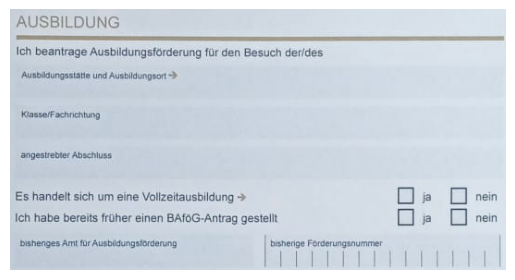

188.04 1253.83 549.3 132.74


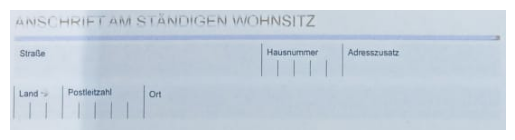

192.87 963.59 535.84 287.9


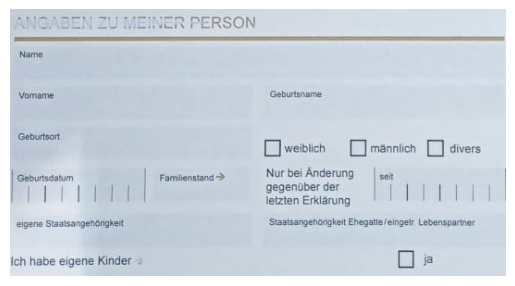

193.48 597.5 552.72 288.8


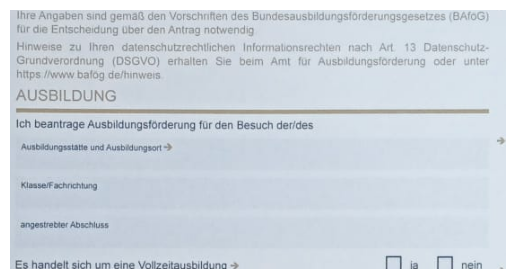

192.3 1169.7 551.84 128.4


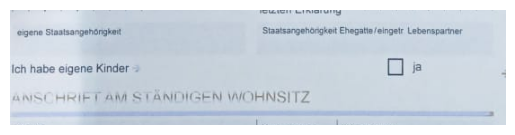

194.17 888.48 550.83 277.32


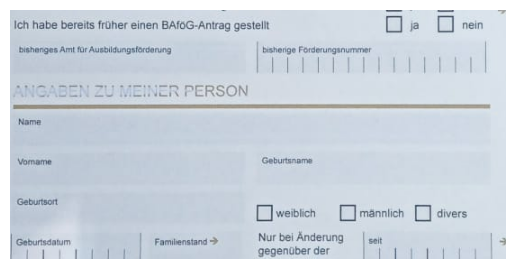

139.8 613.2 554.8 287.4


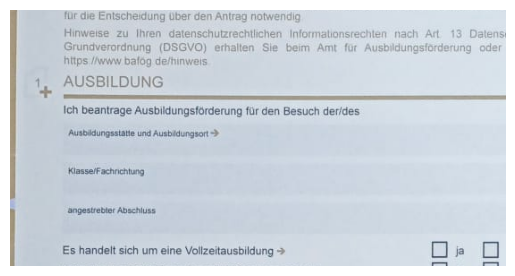

139.8 1194.57 558.6 130.23


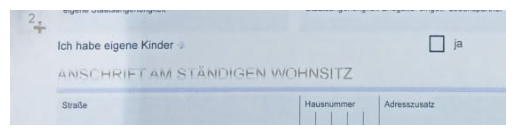

140.21 904.8 557.59 284.6


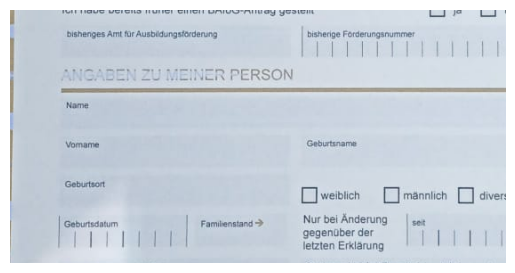

In [23]:
save_directory = 'data'
os.makedirs(save_directory, exist_ok=True)

for box_list in bounding_boxes:
    for box in box_list:
        x, y, w, h = box
        print(x, y, w, h)
        imgCropped = crop(x, y, w, h, IMAGE_PATH + '/original/' + images[0][1])
        save_path = os.path.join(save_directory, f'{x}_{y}_{w}_{h}.jpg')
        cv2.imwrite(save_path, imgCropped)
        plt.axis("off")
        plt.imshow(imgCropped, cmap='gray')
        plt.show()